## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix, plot_confusion_matrix,  ConfusionMatrixDisplay

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9353258667921187023
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3034050884905856135
physical_device_desc: "device: XLA_CPU device"
]


## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.shape

pd.set_option('display.max_columns', None)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
90081,00022399_000.png,No Finding,0,22399,10,M,PA,2522,2673,0.143,0.143,NaN,/data/images_010/images/00022399_000.png
89296,00022167_000.png,Infiltration,0,22167,75,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00022167_000.png
37827,00009951_002.png,No Finding,2,9951,60,F,PA,2048,2500,0.168,0.168,NaN,/data/images_005/images/00009951_002.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_data=all_xray_df
all_labels = np.unique(list(chain(*all_data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_data[c_label] = all_data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
all_data['path'].head()

0    /data/images_001/images/00000001_000.png
1    /data/images_001/images/00000001_001.png
2    /data/images_001/images/00000001_002.png
3    /data/images_001/images/00000002_000.png
4    /data/images_001/images/00000003_000.png
Name: path, dtype: object

In [6]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
#labels=pd.DataFrame()
#labels['pneumonia_class']=all_data['Pneumonia']
#labels['pneumonia_class']=labels['pneumonia_class'].replace(1.0,"YES_Pneumonia")
#labels['pneumonia_class']=labels['pneumonia_class'].replace(0.0,"NO_Pneumonia")

all_data['pneumonia_class']=all_data['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})
all_data[all_data['pneumonia_class'] == 'Positive']
# all_data['pneumonia_class']=all_data['pneumonia_class'].replace(1.0,"YES_Pneumonia")
# all_data['pneumonia_class']=all_data['pneumonia_class'].replace(0.0,"NO_Pneumonia")

all_data['pneumonia_class'].nunique()

2

In [7]:
all_data.Pneumonia.sum()/len(all_data)*100

1.2763110952550838

## Create your training and testing data:

In [8]:
#drop entries with invalid age >100yrs of age
all_data.shape
all_data.drop(all_data[all_data['Patient Age'] >120].index, inplace = True) 
print ("maximum patient age with pneumonia: ", max(all_data[all_data.Pneumonia == 1.0]['Patient Age']))
all_data.shape

maximum patient age with pneumonia:  90


(112104, 29)

In [9]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    X_train, X_val = train_test_split(df, test_size=0.2,stratify = df['pneumonia_class'])
    n_pos=len(X_train[X_train.Pneumonia==1])
    
    x_train_pos=X_train[X_train.Pneumonia==1]  
    x_train_neg = X_train[X_train.Pneumonia==0].sample(n=n_pos)
    X_train_all=x_train_pos
    X_train_all=X_train_all.append(x_train_neg)
    
    v_npos=len(X_val[X_val.Pneumonia==1])
    x_val_pos=X_val[X_val.Pneumonia==1]  
    x_val_neg = X_val[X_val.Pneumonia==0].sample(n=v_npos*4)
    
    X_val_all=x_val_pos
    X_val_all=X_val_all.append(x_val_neg)
    
    
    return X_train_all,X_val_all

In [10]:
x_train, x_val = create_splits(all_data)

In [11]:
(x_train['pneumonia_class']=='Positive').value_counts()

True     1144
False    1144
Name: pneumonia_class, dtype: int64

In [12]:
(x_val['pneumonia_class']=='Negative').value_counts()

True     1144
False     286
Name: pneumonia_class, dtype: int64

In [13]:
 # 20% Positive Cases of Pneumonia

print (x_train.shape,x_val.shape)
x_val['pneumonia_class'].nunique()

print ("Ratio of Pneumonia cases to total cases in training set: ",x_train['Pneumonia'].sum()/len(x_train))
print ("Ratio of Pneumonia cases to total cases in validation set: ",x_val['Pneumonia'].sum()/len(x_val))

(2288, 29) (1430, 29)
Ratio of Pneumonia cases to total cases in training set:  0.5
Ratio of Pneumonia cases to total cases in validation set:  0.2


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [14]:
target_size = (224, 224)
batch_size = 32

In [15]:

def my_image_augmentation(mode="train"):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    if mode == "train":
        my_idg = ImageDataGenerator(rescale=None,
                              preprocessing_function=preprocess_input,     
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.2,
                              zoom_range=0.2)
    else :
        my_idg = ImageDataGenerator(rescale=None,
                                    preprocessing_function=preprocess_input
                                   )
    return my_idg


def make_train_gen(my_train_idg, df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

     
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = target_size, 
                                         batch_size = 64
                                         )
   
    
    return train_gen


def make_val_gen(my_val_idg,valid_df):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = target_size, 
                                         batch_size = 200) 
    
    return val_gen

In [16]:
train_idg = my_image_augmentation() # train
val_idg=my_image_augmentation(mode="val")



In [17]:
train_gen = make_train_gen(train_idg, x_train)
val_gen = make_val_gen(val_idg, x_val)

Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


shape (224, 224, 3)


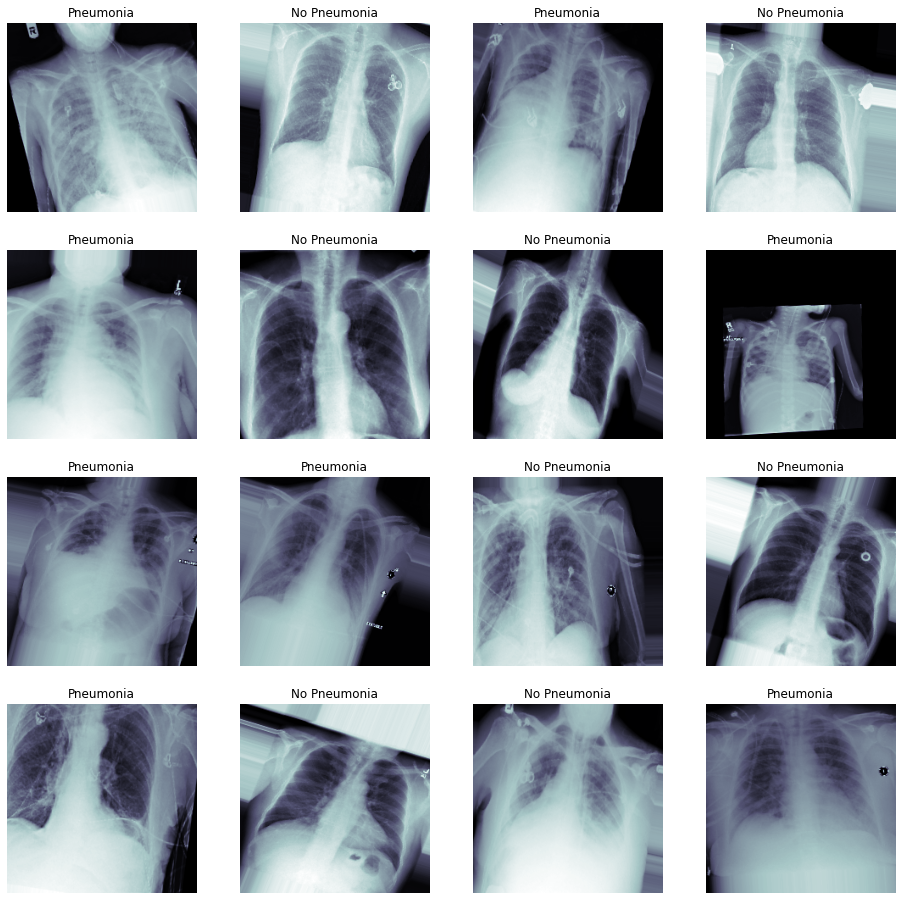

In [18]:
t_x, t_y = next(train_gen)
print("shape", t_x[0].shape)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

In [19]:
val_gen.labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


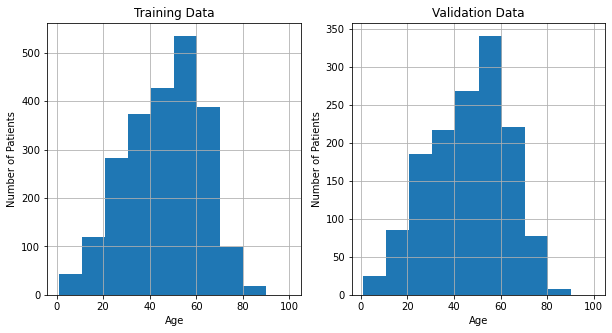

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(x_train['Patient Age'],range=(1,100))
ax[0].set_xlabel("Age")
ax[0].set_title("Training Data")
ax[0].set_ylabel("Number of Patients")
ax[0].grid("on")

ax[1].hist(x_val['Patient Age'],range=(1,100))
ax[1].set_xlabel("Age")
ax[1].set_title("Validation Data")
ax[1].set_ylabel("Number of Patients")
ax[1].grid("on")

plt.show()

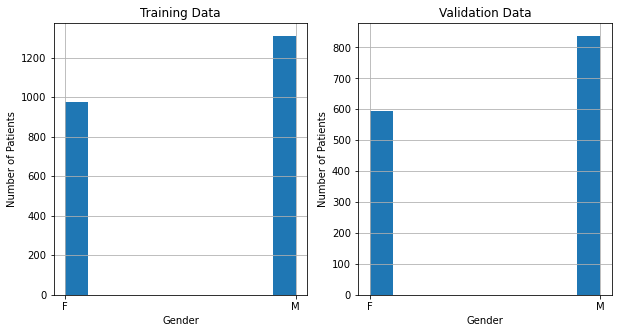

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(x_train['Patient Gender'])
ax[0].set_xlabel("Gender")
ax[0].set_title("Training Data")
ax[0].set_ylabel("Number of Patients")
ax[0].grid("on")

ax[1].hist(x_val['Patient Gender'])
ax[1].set_xlabel("Gender")
ax[1].set_title("Validation Data")
ax[1].set_ylabel("Number of Patients")
ax[1].grid("on")

plt.show()

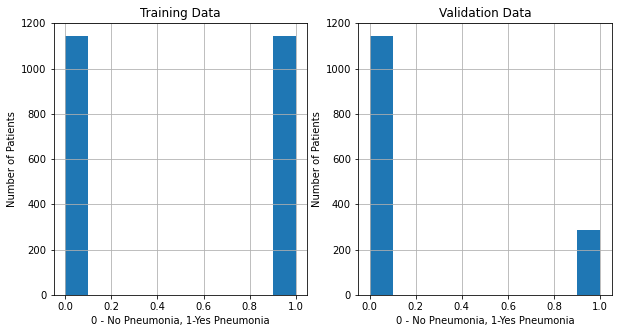

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(x_train['Pneumonia'])
ax[0].set_xlabel("0 - No Pneumonia, 1-Yes Pneumonia")
ax[0].set_title("Training Data")
ax[0].set_ylabel("Number of Patients")
ax[0].grid("on")

ax[1].hist(x_val['Pneumonia'])
ax[1].set_xlabel("0 - No Pneumonia, 1-Yes Pneumonia")
ax[1].set_title("Validation Data")
ax[1].set_ylabel("Number of Patients")
ax[1].grid("on")

plt.show()

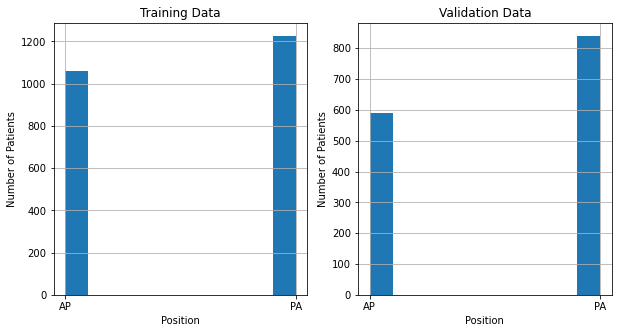

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(x_train['View Position'])
ax[0].set_xlabel("Position")
ax[0].set_title("Training Data")
ax[0].set_ylabel("Number of Patients")
ax[0].grid("on")

ax[1].hist(x_val['View Position'])
ax[1].set_xlabel("Position")
ax[1].set_title("Validation Data")
ax[1].set_ylabel("Number of Patients")
ax[1].grid("on")

plt.show()

In [24]:
trainX, trainY = train_gen.next()

In [25]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [26]:
from collections import Counter
Counter(valY)

Counter({1.0: 42, 0.0: 158})

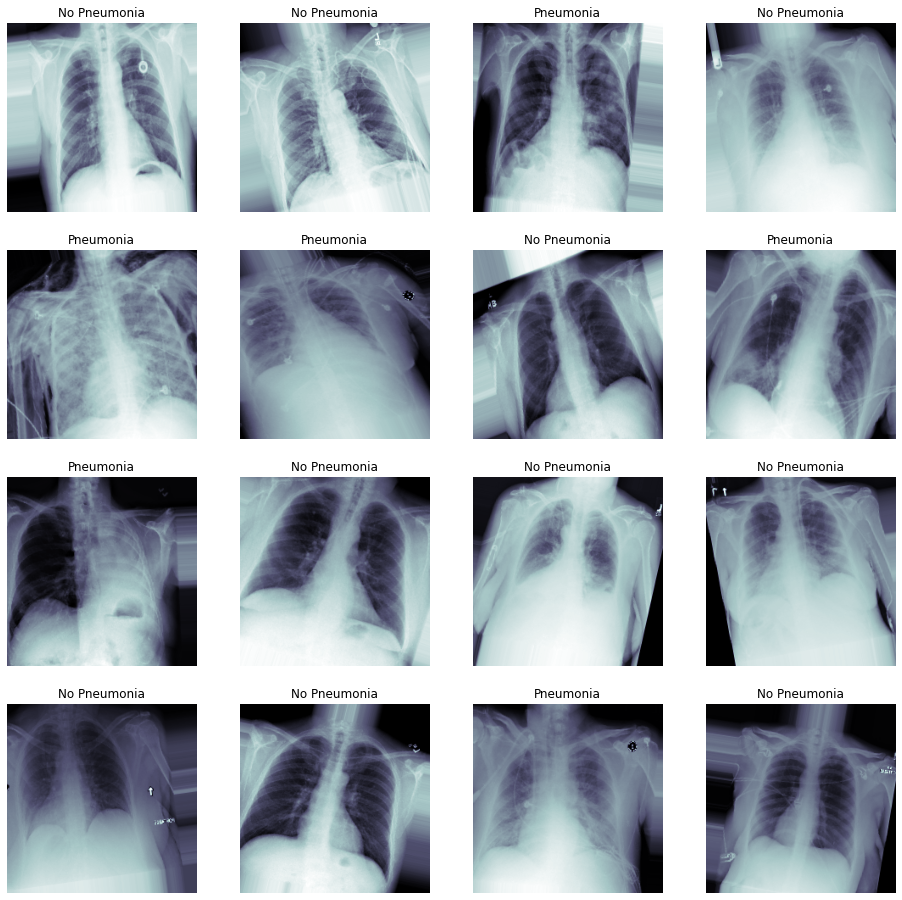

In [27]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [28]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    #model.summary()
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,outputs=transfer_layer.output)
    return vgg_model


In [29]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    for layer in vgg_model.layers:
        layer.trainable = False
    vgg_model.summary()
    my_model = Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
    my_model.add(Dense(4096, activation='relu'))
    my_model.add(Dropout(0.6))
    my_model.add(Dense(128, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=5e-5)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [30]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor='loss', 
                       mode='min', 
                       patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                                  patience=3, min_lr=1e-5)

callbacks_list = [checkpoint, early, reduce_lr]

### Start training! 

In [31]:
my_vgg=load_pretrained_model()
my_model=build_my_model(my_vgg)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [32]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [33]:
## train your model
# Todo
# history = my_model.fit_generator(train_gen, 
#                            validation_data = (valX, valY), 
#                            epochs = 10, 
#                            callbacks = callbacks_list)

In [34]:
#pd.DataFrame(history.history).to_csv("out/history.csv")
performance = []
history = pd.read_csv('out/history.csv')
#history_df=pd.DataFrame(history.history)
history_df=pd.DataFrame(history)
performance.append(history_df[history_df['val_loss']==min(history_df['val_loss'])])
performance

[   Unnamed: 0  val_loss  val_binary_accuracy      loss  binary_accuracy     lr
 6           6  0.608829                 0.75  0.637251         0.640734  0.001]

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

Multiple training iterations show that the after about 80-90 epochs, even though the training loss reduces, the validations loss begins to increase. Accordingly, even with a low training loss of about 0.45, the AUC is worse than the AUC as seen below. We thus optimise AUC with early stopping.

In [35]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

200/200 [==============================] - 160s 802ms/step


In [46]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    res = auc(fpr, tpr)
    print("AUC-ROC is: " + str(res))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    c_ax.figure.savefig('out/plot_auc')
    return fpr, tpr, thresholds, res

## what other performance statistics do you want to include here besides AUC? 


def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    c_ax.figure.savefig('out/precision-recall')
    return precision, recall, thresholds
                    
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

#Also consider plotting the history of your model training:

def plot_history(history):
    # Todo
    #loss = history.history['loss']
    loss = history['loss']
    #vloss= history.history['val_loss']
    vloss= history['val_loss']
    fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
    c_ax.plot(range(len(loss)), loss,label="Training loss",c='r')
    c_ax.plot(range(len(vloss)), vloss,label="Val loss loss",c='b')
    c_ax.legend()
    c_ax.set_xlabel('Epoch')
    c_ax.set_ylabel(' Loss')
    c_ax.figure.savefig('out/Model_Training_Performance')


10


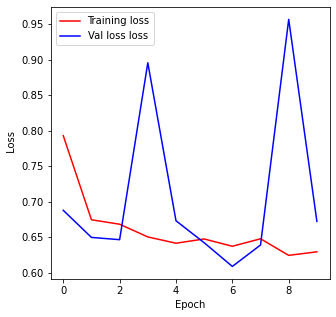

In [47]:
## plot figures
# Todo

# print (len(history.history['loss']))
print (len(history['loss']))
plot_history(history)

AUC-ROC is: 0.6281645569620253


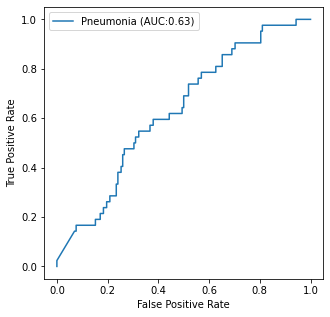

In [48]:
fpr, tpr, thresholds_ROC, AUC = plot_auc(valY, pred_Y)

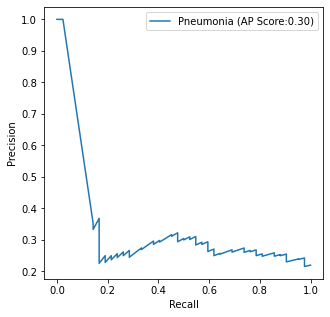

In [49]:
precision, recall, threshold = plot_precision_recall_curve(valY,pred_Y)

In [50]:
def plot_roc(t_y, p_y):
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label = 1)
#    np.append(thresholds, 1)
    plt.plot(fpr,tpr)
    plt.style.use('ggplot')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Chance', alpha=.8)
    plt.savefig('out/ROC_Curve')
    plt.show()
    
    return fpr, tpr, thresholds

In [51]:
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_f1(t_y,p_y):
    precision, recall, threshold = plot_precision_recall_curve(t_y,p_y)
    f1 = calc_f1(precision, recall)
    plt.style.use('ggplot')
    plt.plot(threshold, f1)
    plt.title('F1 vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    plt.savefig('out/F1_Threshold')
    plt.show()
    
    return precision, recall, f1, threshold

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [52]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

for id in range(len(precision)-2):
    print(f'p={precision[id]},r={recall[id]},thresh={thresholds[id]},F1 Score is: ' + str(calc_f1(precision[id],recall[id])))

p=0.2198952879581152,r=1.0,thresh=0.4807018041610718,F1 Score is: 0.3605150214592274
p=0.21578947368421053,r=0.9761904761904762,thresh=0.48094460368156433,F1 Score is: 0.35344827586206895
p=0.21693121693121692,r=0.9761904761904762,thresh=0.48096585273742676,F1 Score is: 0.354978354978355
p=0.21808510638297873,r=0.9761904761904762,thresh=0.48147544264793396,F1 Score is: 0.3565217391304347
p=0.2192513368983957,r=0.9761904761904762,thresh=0.4818881154060364,F1 Score is: 0.3580786026200873
p=0.22043010752688172,r=0.9761904761904762,thresh=0.48208707571029663,F1 Score is: 0.35964912280701755
p=0.22162162162162163,r=0.9761904761904762,thresh=0.48210424184799194,F1 Score is: 0.36123348017621143
p=0.22282608695652173,r=0.9761904761904762,thresh=0.4821382761001587,F1 Score is: 0.36283185840707965
p=0.22404371584699453,r=0.9761904761904762,thresh=0.48220810294151306,F1 Score is: 0.36444444444444446
p=0.22527472527472528,r=0.9761904761904762,thresh=0.48282870650291443,F1 Score is: 0.3660714285714

In [53]:
# Look at the threshold where precision is 0.55
precision_value = 0.33
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

SyntaxError: invalid syntax (<ipython-input-53-0dece35db420>, line 7)

In [54]:
recall_value = 0.75
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))

print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.26229508196721313
Recall is: 0.7619047619047619
Threshold is: 0.49147284
F1 Score is: 0.3902439024390244


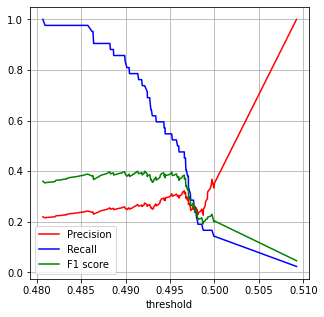

In [55]:
f1sc=[]
for p,r in zip(precision[:-1],recall[:-1]):
    f1sc.append(calc_f1(p,r))


fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
c_ax.plot(thresholds, precision[:-1],label="Precision",c='r')
c_ax.plot(thresholds, recall[:-1],label="Recall",c='b')
c_ax.plot(thresholds, f1sc,label="F1 score",c='g')
c_ax.legend()
c_ax.set_xlabel('Threshold')
plt.grid("on")

              


In [56]:
t1=[]
t1=np.array([1.0 if x> 0.522 else 0. for x in pred_Y])

In [57]:
#95% confidence range
tn, fp, fn, tp = confusion_matrix(valY,t1).ravel()
adj_rec=(tp+2)/(tp+fn+4)
adj_prec=(tp+2)/(tp+fp+4)
adj_f1=calc_f1(adj_prec,adj_rec)
stde=np.sqrt(adj_f1*(1-adj_f1)/(4*len(valY)))
intrl=adj_f1 - 1.96*stde
intrh=adj_f1 + 1.96*stde

print("The f1 score confidence interval is ({0:.4f},{1:.4f})".format(intrl, intrh))

f1 score onfidence interval is (0.0612,0.0988)


In [58]:
def find_ROC_thresh(fpr,tpr,thresh):
    dist1=0
    dist2=0
    tprmax = 0
    for i in range(len(fpr)):
        dist2 = tpr[i] - fpr[i]
        if dist2 > dist1:
            dist1 = dist2
            tprmax=tpr[i]
        else:
            continue
    df = pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresh})
    threshmax = df['threshold'][df['tpr']==tprmax].iloc[-1]
    return threshmax

In [59]:
thresh_ROC = find_ROC_thresh(fpr,tpr, thresholds_ROC)
print("The value for thresh_ROC is " + str(thresh_ROC))

thresh_ROC is 0.49445698


In [61]:
val_gen.labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [69]:
#ROC Threshold Confusion Matrix:
pred_YROC = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_ROC:
        pred_YROC.append(1)
    else:
        pred_YROC.append(0)

tn,fp,fn,tp =confusion_matrix(valY, pred_YROC).ravel()
print (tp, fp,"\n",fn,tn)




23 57 
 19 101


In [70]:
val_gen.labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


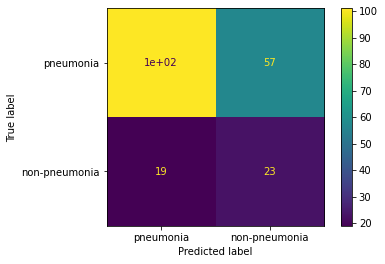

In [73]:
cm = confusion_matrix(valY, pred_YROC)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['pneumonia','non-pneumonia'])
disp.plot().figure_.savefig('confusion_matrix.png')

In [87]:
def get_statistics(t_y, p_y, threshold):
    
    tn, fp, fn, tp = confusion_matrix(t_y, p_y).ravel()
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1_score = (2 * precision * recall) / (precision + recall)
    
    accuracy = (tp + tn) / (tp + fn + tn + fp)
    
    return [threshold, sensitivity, specificity, precision, recall, f1_score, accuracy]

In [90]:
statistics = []

for threshold in np.arange(0.0, 1.0, 0.1):
    pred_Y = (pred_Y >= threshold)
    statistics.append(get_statistics(valY, pred_Y, threshold))

df = pd.DataFrame(statistics, columns=['Threshold', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])

df

,Threshold,Sensitivity,Specificity,Precision,Recall,F1 Score,Accuracy
0,0.0,1.0,0.0,0.21,1.0,0.347107,0.21
1,0.1,1.0,0.0,0.21,1.0,0.347107,0.21
2,0.2,1.0,0.0,0.21,1.0,0.347107,0.21
3,0.3,1.0,0.0,0.21,1.0,0.347107,0.21
4,0.4,1.0,0.0,0.21,1.0,0.347107,0.21
5,0.5,1.0,0.0,0.21,1.0,0.347107,0.21
6,0.6,1.0,0.0,0.21,1.0,0.347107,0.21
7,0.7,1.0,0.0,0.21,1.0,0.347107,0.21
8,0.8,1.0,0.0,0.21,1.0,0.347107,0.21
9,0.9,1.0,0.0,0.21,1.0,0.347107,0.21


In [96]:
t_y

array([0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.], dtype=float32)

In [98]:
valY

array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [99]:
# all these values are True which is a problem

pred_Y

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

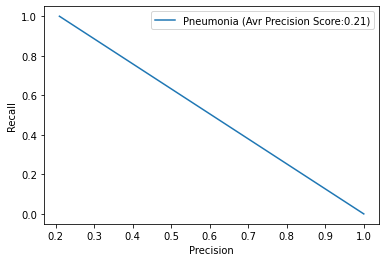

In [92]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1)
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (Avr Precision Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Precision')
    c_ax.set_ylabel('Recall')
    c_ax.figure.savefig('out/pr_plot')

    return 2*(precision*recall)/(precision + recall), precision, recall, thresholds
    

f1, precision, recall, thresholds = plot_pr(valY, pred_Y)

In [93]:
metric_df = pd.DataFrame({'f1':f1[:-1], 'precision':precision[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

In [94]:
metric_df

,f1,precision,recall,thresholds
0,0.347107,0.21,1.0,True


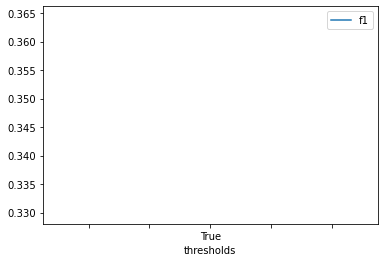

In [95]:
metric_df.plot(x ='thresholds', y='f1', kind = 'line')

In [78]:
def plot_precision_recall_curve(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    plt.plot(recall, precision , label='Pneumonia')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title("Precision-Recall Curve")
    plt.legend(['Pneumonia'], loc='lower right')
    plt.savefig('out/precision_recall')
    plt.show()

    return precision, recall, thresholds

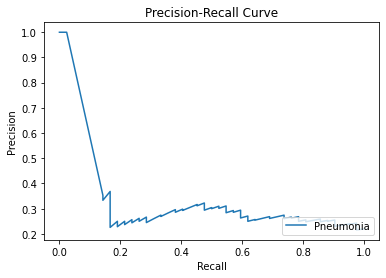

In [79]:

precision, recall, thresholds = plot_precision_recall_curve(valY, pred_Y)
precision = np.array(precision)
recall = np.array(recall)
f1_score = 2 * (precision*recall)/(precision+recall)

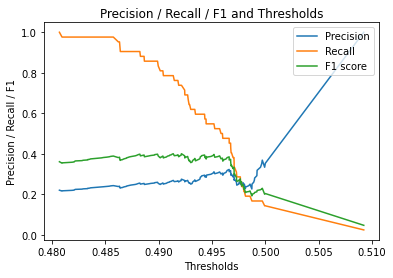

In [80]:
precision = np.array(precision)
recall = np.array(recall)
f1_score = 2 * (precision*recall)/(precision+recall)

def plot_score_thresholds(precision, recall, f1_score, thresholds):
    plt.plot(thresholds, precision, label='Precision')
    plt.plot(thresholds, recall, label ='Recall')
    plt.plot(thresholds, f1_score, label = 'F1 score')
    plt.xlabel('Thresholds')
    plt.ylabel('Precision / Recall / F1')
    plt.title("Precision / Recall / F1 and Thresholds")
    plt.legend(['Precision', 'Recall', 'F1 score'], loc='upper right')
    plt.savefig('out/score_threshold')
    plt.show()
plot_score_thresholds(precision[:-1], recall[:-1], f1_score[:-1], thresholds)

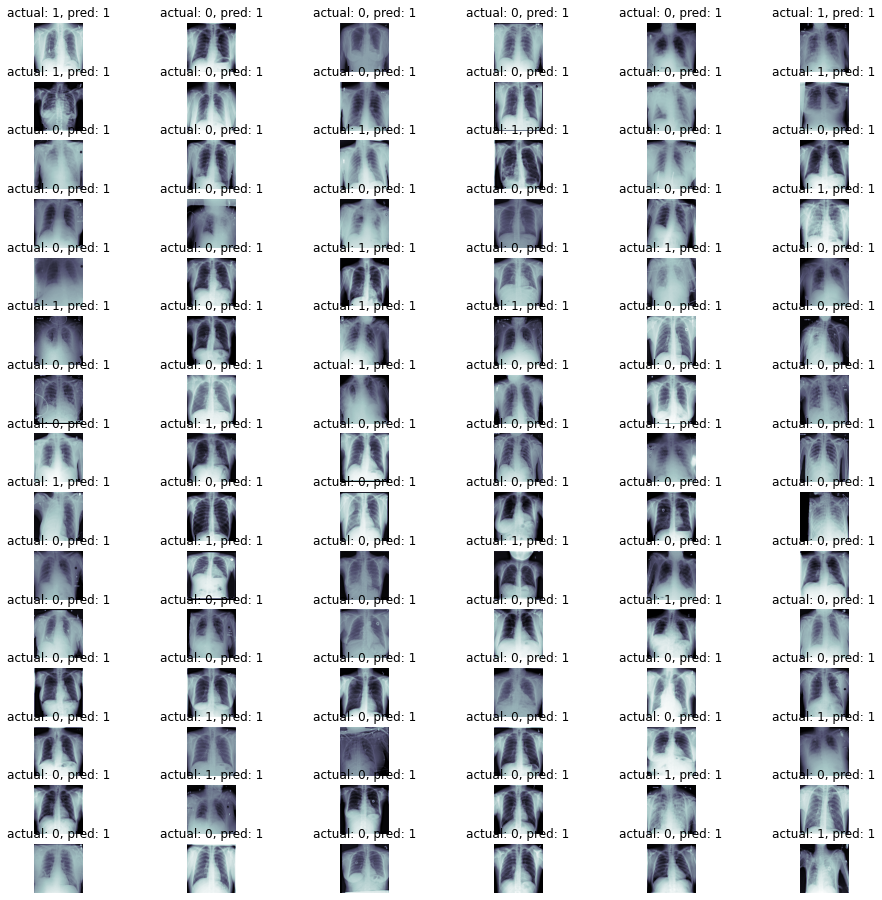

In [84]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
chosen_threshold=0.522
fig, m_axs = plt.subplots(15, 7, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > chosen_threshold:
            c_ax.set_title('actual: 1, pred: 1')
        else: 
            c_ax.set_title('actual: 1, pred: 1')
    else:
        if pred_Y[i] > chosen_threshold: 
            c_ax.set_title('actual: 0, pred: 1')
        else:
            c_ax.set_title('actual: 0, pred: 1')
    c_ax.axis('off')
    i=i+1

In [82]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)